In [46]:
# Data update functionality
import os

from fabric import ThreadingGroup,Connection
from fabric.transfer import Transfer

# global configuration parameters
hosts = ["52.13.145.44", "52.89.179.9", "54.191.161.231", "54.218.172.167", "54.218.29.151", "34.222.0.168","18.237.96.142","54.68.198.213"]
key_file_loc = "/Users/sfeygi/.ssh/beam_competitions_key.pem"
dest_root = "/Users/sfeygi/current_code/others/prize_starter_kit/search-output/fixed/"

def connect_parallel(hosts,key_file_loc):
    return ThreadingGroup(*hosts,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def connect_single(host, key_file_loc):
    return Connection(host,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def run(cmd, connection):
    return connection.run(cmd)

def run_n(cmd, connections):
    return [run(cmd,connection) for connection in connections]

def rsync_results(hostname, host_ip, key_file_loc, dest_root):
    return os.system(
        'rsync -avz -e "ssh -i {key_file_loc}" ubuntu@{host_ip}:/home/ubuntu//Uber-Prize-Starter-Kit/search-output-Exploration_1-fixed_inputs/ {dest_root}{hostname} --exclude="*/ITERS/" --exclude="*/output*" --exclude="*/competition/viz/" --exclude="*/summaryStats/"'.format(
            dest_root=dest_root,key_file_loc=key_file_loc, hostname=hostname, host_ip=host_ip))

# global other
host_names = ["host{}".format(str(i + 1)) for i in range(len(hosts))]
connection = connect_parallel(hosts,key_file_loc)

In [47]:
# try:
#     run('cd /home/ubuntu/Uber-Prize-Starter-Kit/utilities &&  \
#         git pull origin vgv/#55-adapt_ramdom_search', connection)
# except UnexpectedExit:
#     print("Already pulled in latest!")
# Ensure that docker image on server is latest (somewhat orthogonal to this notebook, but leaving here for now)
run('docker pull beammodel/beam-competition:0.0.1-SNAPSHOT',connection)


0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
54f7e8ac135a: Already exists
d6341e30912f: Already exists
087a57faf949: Already exists
5d71636fb824: Already exists
0c1db9598990: Already exists
2eeb5ce9b924: Already exists
5b17b6f4d4e0: Already exists
f1abee0af377: Already exists
298587aefca5: Already exists
d19a52a4201b: Already exists
c4b97e37313f: Already exists
0da75cc02c04: Already exists
01556cb5c24d: Already exists
59cec1e23469: Already exists
a4e8cfda4e7e: Already exists
c2c7d8e9c50f: Already exists
26431a57825a: Already exists
916606cef963: Already exists
77e7c1d02cf0: Already exists
fbaced5f3ab6: Already exists
da3c75a71849: Already exists
2c15ce938ad2: Already exists
4cef7fc3dfe3: Already exists
a0dd5a72f852: Already exists
25f9d1f0e84f: Already exists
ad122776ffa2: Pulling fs layer
ea5e031f628d: Pulling fs layer
54de75e19a6b: Pulling fs layer
613a4d641bfc: Pulling fs layer
f69a93a19755: Pulling fs layer
42b818daf513: Pulling fs layer
366848a7774d: Pulling fs layer
61

54de75e19a6b: Verifying Checksum
54de75e19a6b: Download complete
ea5e031f628d: Download complete
ea5e031f628d: Download complete
54de75e19a6b: Verifying Checksum
54de75e19a6b: Download complete
ea5e031f628d: Verifying Checksum
ea5e031f628d: Download complete
54de75e19a6b: Verifying Checksum
54de75e19a6b: Download complete
ad122776ffa2: Verifying Checksum
ad122776ffa2: Download complete
613a4d641bfc: Verifying Checksum
613a4d641bfc: Download complete
54de75e19a6b: Verifying Checksum
54de75e19a6b: Download complete
f69a93a19755: Download complete
613a4d641bfc: Verifying Checksum
613a4d641bfc: Download complete
613a4d641bfc: Verifying Checksum
613a4d641bfc: Download complete
366848a7774d: Verifying Checksum
366848a7774d: Download complete
f69a93a19755: Verifying Checksum
f69a93a19755: Download complete
f69a93a19755: Verifying Checksum
f69a93a19755: Download complete
613a4d641bfc: Download complete
613a4d641bfc: Verifying Checksum
613a4d641bfc: Download complete
613a4d641bfc: Verifying Che

{<Connection host=52.13.145.44 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=52.89.179.9 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.218.172.167 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.191.161.231 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.218.29.151 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=18.237.96.142 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.68.198.213 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=34.222.0.168 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>}

In [2]:
# Pull latest results from server
[rsync_results(hostname, host_ip, key_file_loc,dest_root) for hostname, host_ip in list(zip(host_names, hosts))[5:]]

[5888, 5888, 5120]

In [3]:
import pandas as pd
import seaborn as sns
# import dask.dataframe as dd
from collections import defaultdict
import re
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [4]:
%matplotlib inline

In [5]:
# Parsing utilities
def split_range(range_repr):
    """
    Split's out a mathematial range representation into its component bounds.
    
    Exclusive ('(',')') bounds will have the left and/or right bounds properly
    augmented with +1 and -1, respectively. Inclusive bounds ('[',']') will remain
    as written.
    
    Parameters
    ----------
    range_repr : str
        A formatted representation of the range with exclusive and inclusive
        bounds represented as '(',')' and/or '[',']', respectively, for example,
        the range "(300:500]" represents all numbers between 300 (exclusive) and 500
        (inclusive).
    
    Returns
    -------
    str
        The input range representation as pair of integers with the ':' remaining to permit
        easy splitting with the series `str.split` function when the `expand` argument is `True`.
    
    Examples
    --------
    >>> split_range("(47000:202000]")
    '47001:202000'
    >>> split_range("(47000:202000]")
    '155000:176000'
    
    """
    if isinstance(range_repr,float):
        return "0:120"
    l,r = range_repr.strip("(),[]").split(":")
    l = int(l) + 1 if range_repr[0] is '(' else int(l) + 0
    r = int(r) - 1 if range_repr[-1] is ')' else int(r) + 0
    return "{}:{}".format(l,r)

# input_db = pd.concat(all_input_dfs).set_index("output_key")
def concat_and_set_index(df,name):
    return pd.concat(df[name]).set_index("output_key")
def expand_range_column(in_df,field):
    in_series = in_df.loc[:,field]
    in_df = in_series.apply(split_range).str.split(":",expand=True)
    in_df.columns = ["{}_low".format(field),"{}_high".format(field)]
#     in_df
    return in_df

def split_input_range(input_df,input_fields):
    tmp_res = []
    for input_field in input_fields:
        split_input_field=expand_range_column(input_df,input_field)
        input_df.drop(input_field,axis=1,inplace=True)
        tmp_res.append(split_input_field)
    input_type_df = pd.concat(tmp_res,axis=1)
    return pd.concat([input_df,input_type_df],axis=1)

def merge_input_type_df_with_score(input_df,scores_df,score_type):
    sub_scores = scores_df.loc[score_type]
    score_df = pd.merge(sub_scores,input_df,how="outer",right_index=True,left_on="output_key").set_index("output_key")
    return score_df.dropna(axis=0)

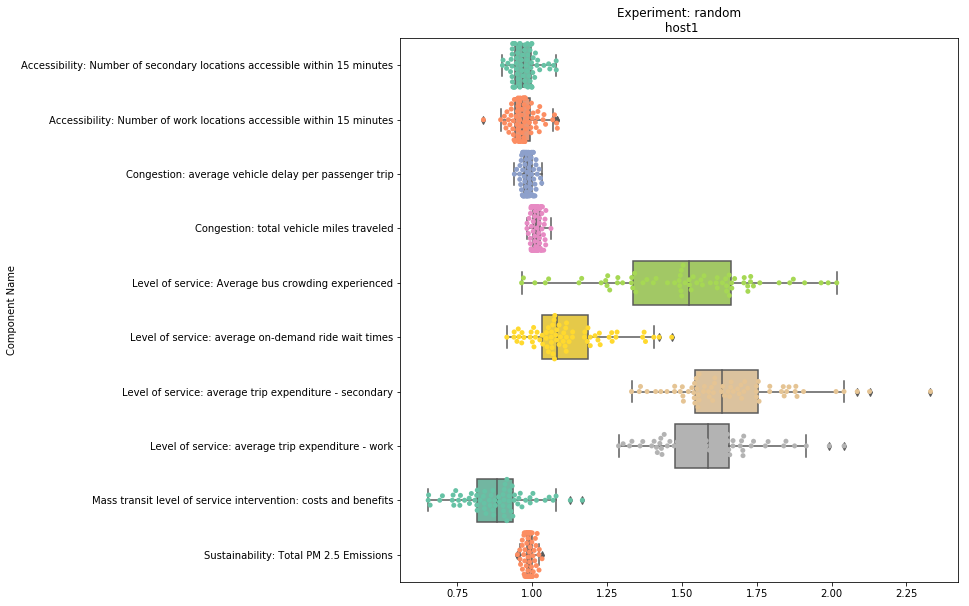

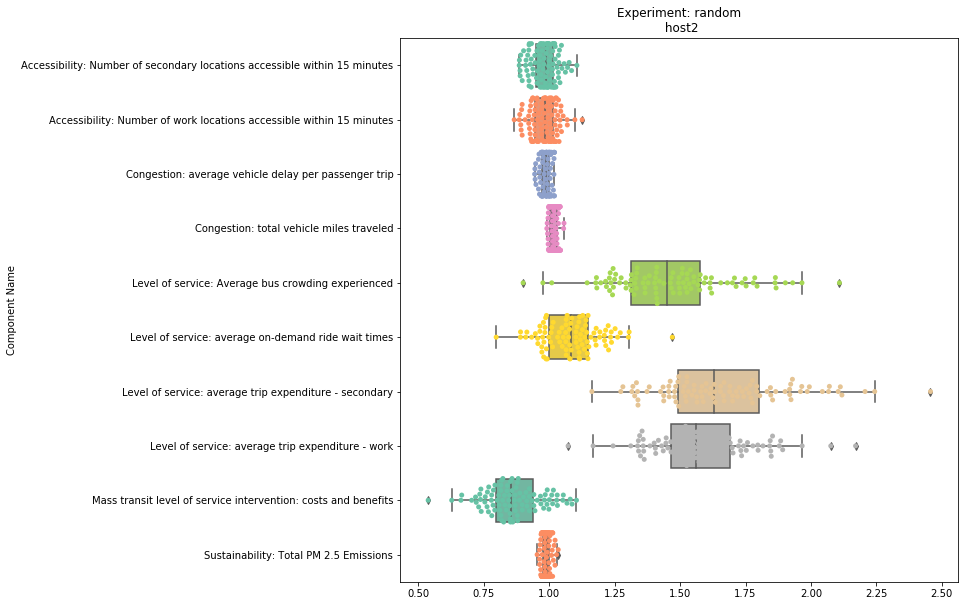

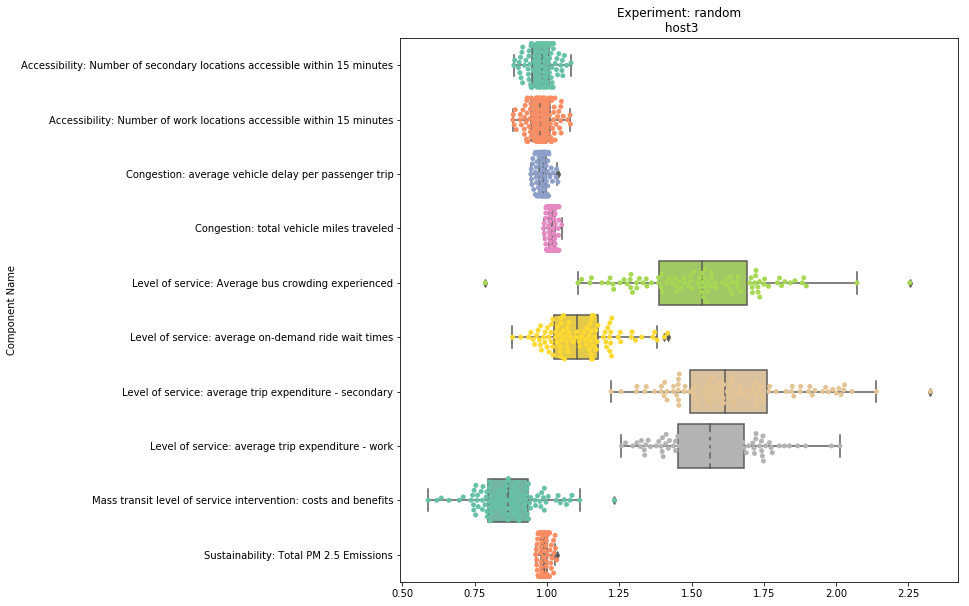

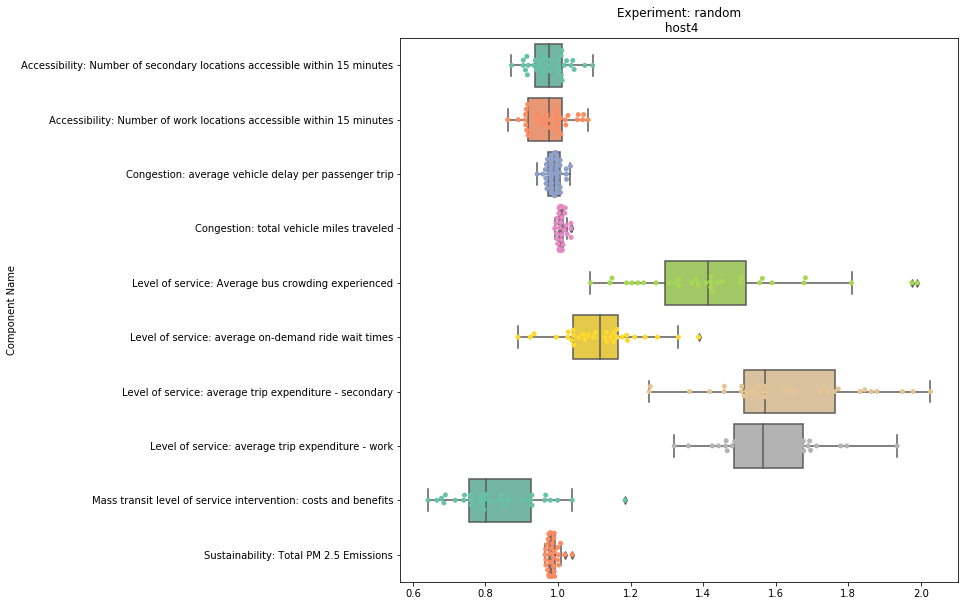

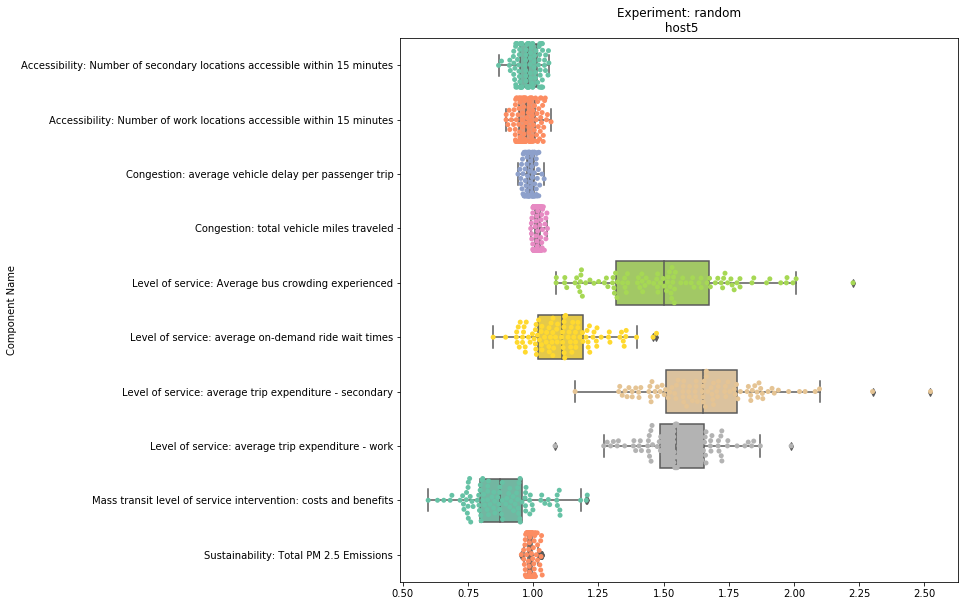

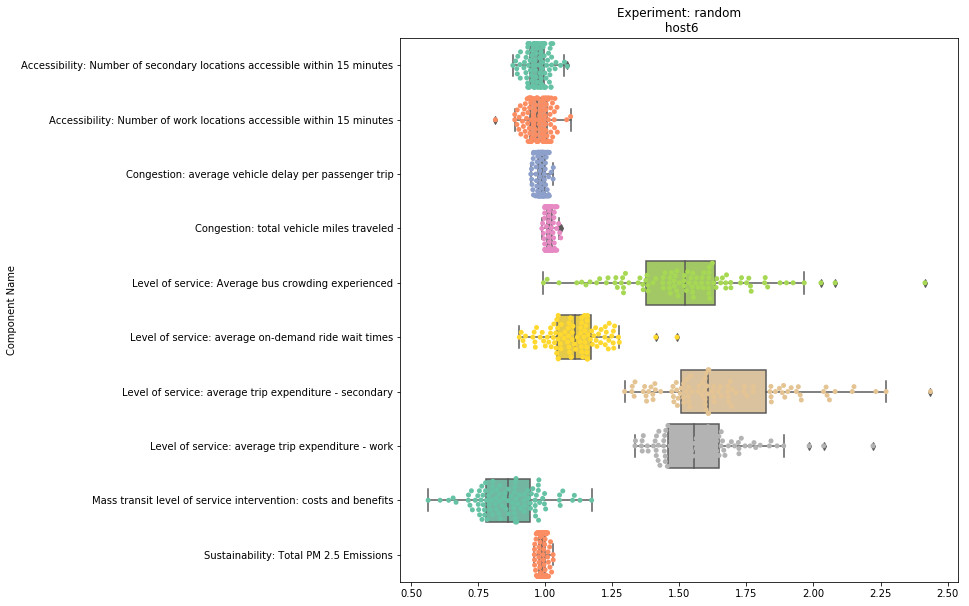

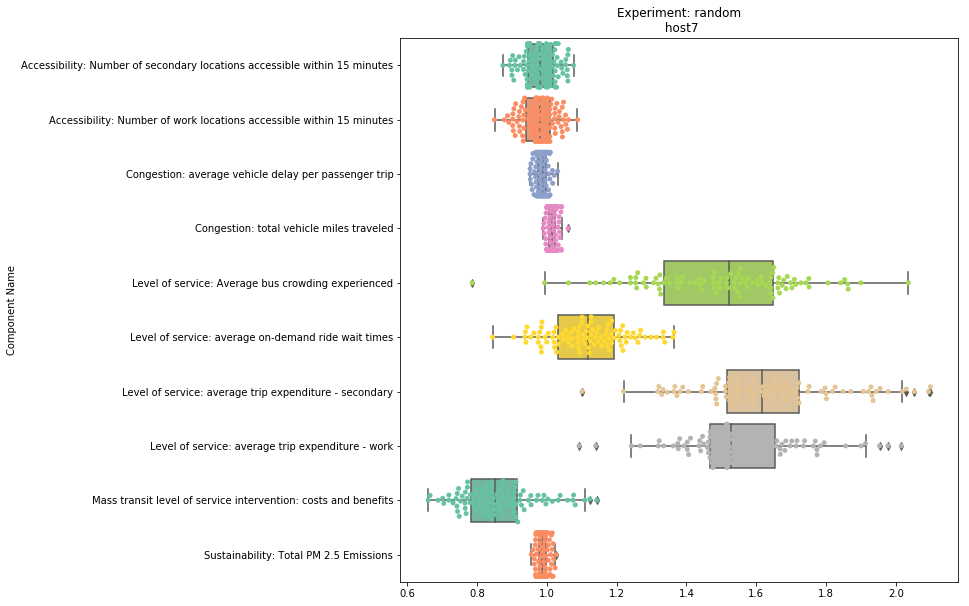

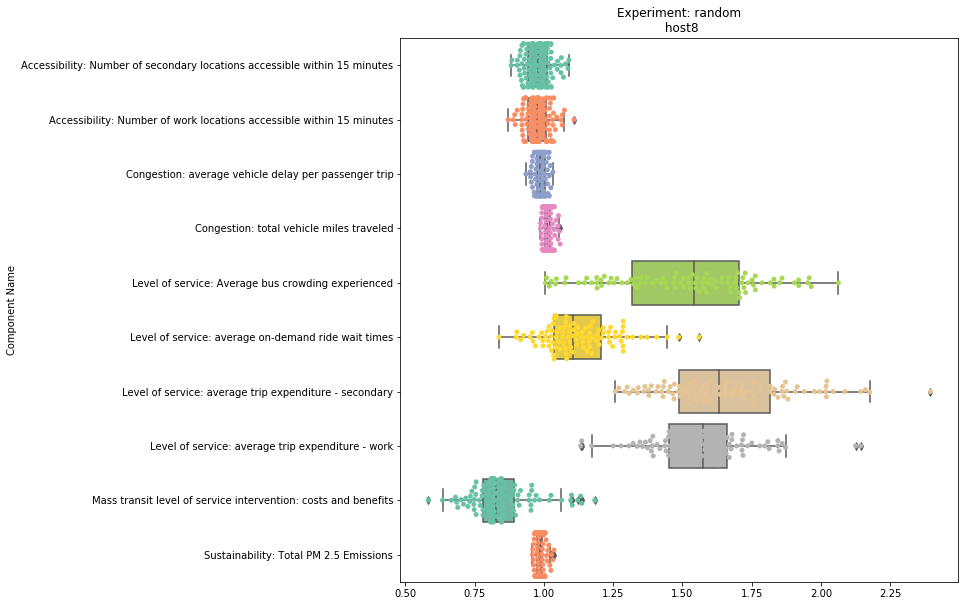

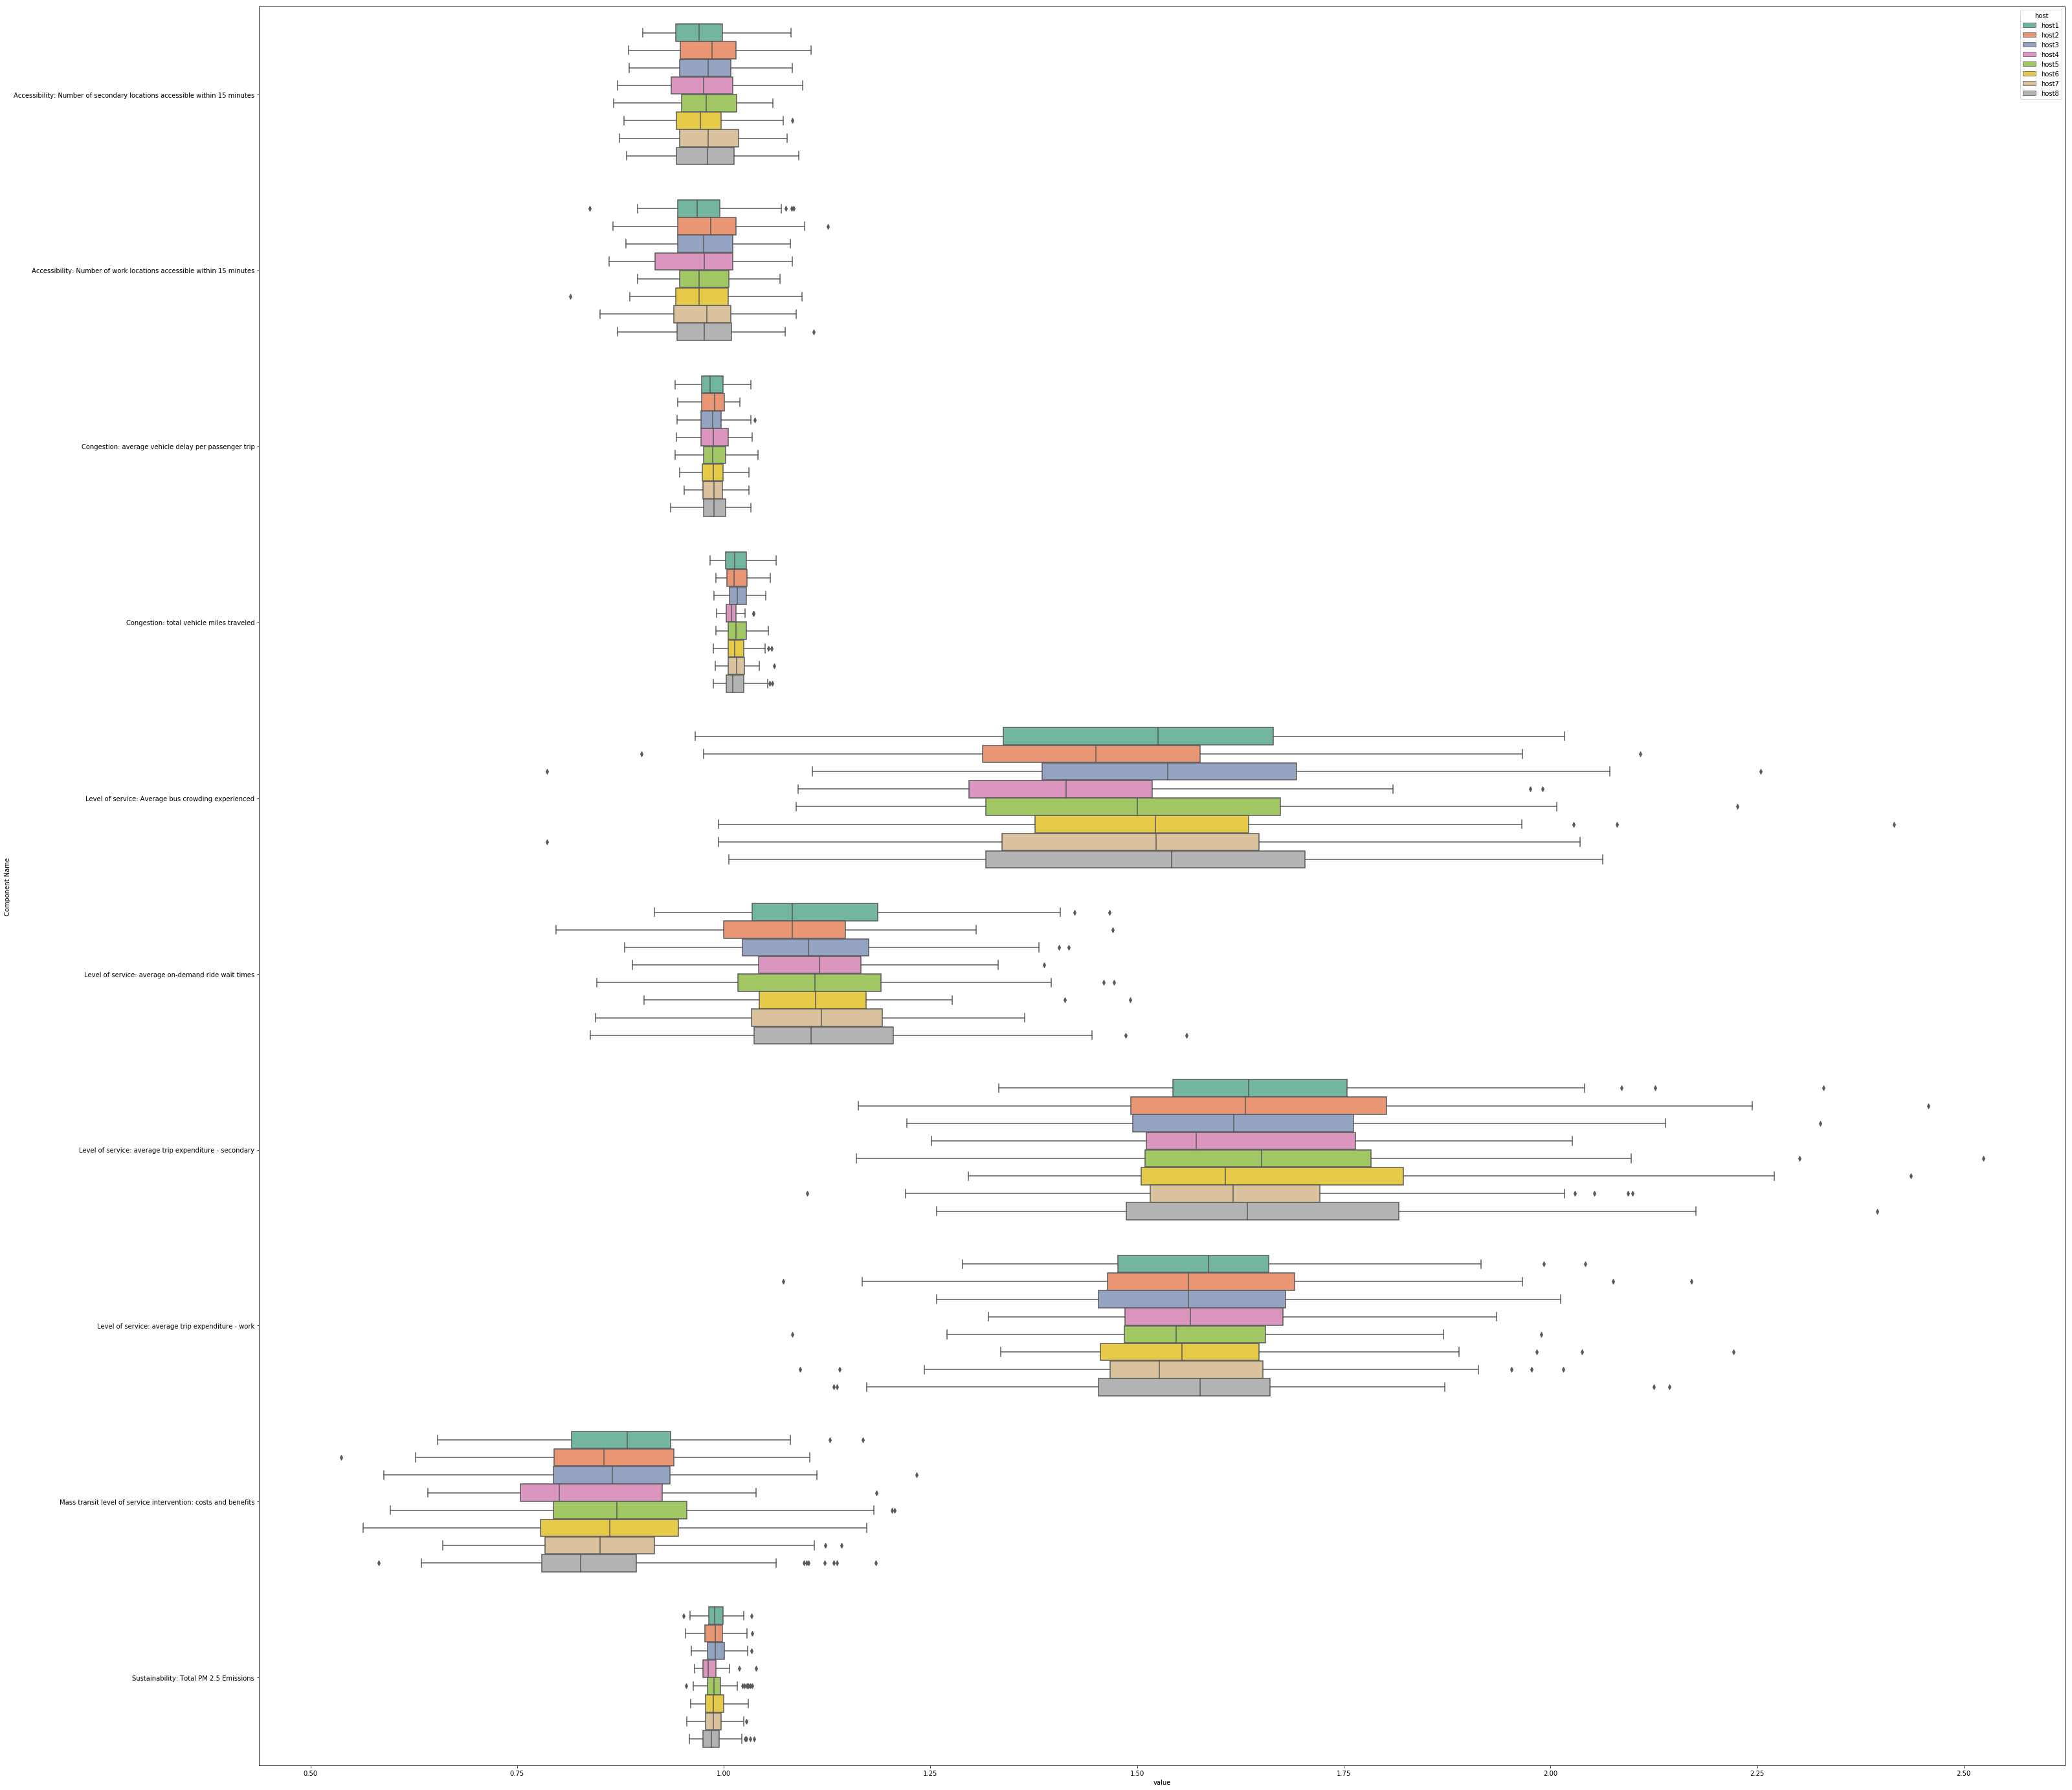

In [6]:
# collect, parse, and concatenate scores as well as plot by condition
import glob
experiment_types = ['random']
wide_score_dfs = []
for experiment_type in experiment_types:

    scores_dfs={}
    for host in host_names:
        try:
            common="../search-output/{}/{}/".format(experiment_type,host)
            output_dirs = glob.glob(common+"output*/sioux_faux/sioux_faux-15k*/competition/")


            sub_score_dfs = []
            all_input_dfs = defaultdict(list)
            SUBMISSION_INPUTS_DIR_NAME = "submission-inputs/"
            SUB_SCORE_NAME = "submissionScores.csv"
            input_names = ("FrequencyAdjustment","ModeIncentives","PtFares","VehicleFleetMix")

            for output_dir in output_dirs:
                # Load sub_score_dfs
                sub_score_file = output_dir + SUB_SCORE_NAME
                if not Path(sub_score_file).is_file():
                    continue
                score_df = pd.read_csv(sub_score_file,index_col="Component Name")
                output_key = re.findall("^.*output[_|-](.*?)(?:/sioux.*)$",output_dir)[0]
                if "RS" not in output_key:  # filter out old runs for now
                    continue
                score_df.loc[:,"output_key"] = output_key
                sub_score_dfs.append(score_df[["Raw Score","output_key"]])

                for input_name in input_names:
                    input_file = output_dir + SUBMISSION_INPUTS_DIR_NAME +"/"+ input_name+".csv"
                    if input_name == 'ModeIncentives':
                        input_df = pd.read_csv(input_file,dtype={'age':str})
                    else:
                        input_df = pd.read_csv(input_file)
                    if input_df.shape[0] == 0:
                        continue
                    input_df.loc[:,"output_key"] = output_key
                    input_df.index.name = 'obs_num'
                    all_input_dfs[input_name].append(input_df)


            freq_df = concat_and_set_index(all_input_dfs,"FrequencyAdjustment").drop('exact_times',axis=1)
            mode_df = concat_and_set_index(all_input_dfs,"ModeIncentives")
            ptfare_df = concat_and_set_index(all_input_dfs,"PtFares")
            vfm_df = concat_and_set_index(all_input_dfs,"VehicleFleetMix").drop("agencyId",axis=1)

            trip_id_factors = pd.factorize(freq_df.loc[:,"trip_id"])
            freq_df.loc[:,"trip_id"]=trip_id_factors[0]

            mode_factors = pd.factorize(mode_df.loc[:,"mode"])
            mode_df.loc[:,"mode"]=mode_factors[0]

            a,b = pd.factorize(list(set(ptfare_df.loc[:, "routeId"].values).union(set(ptfare_df.loc[:,"routeId"]))))
            mapping = dict(zip(b,a))
            ptfare_df.loc[:,"routeId"]=ptfare_df.loc[:,"routeId"].apply(lambda x: mapping[x])
            vfm_df.loc[:, "routeId"] = vfm_df.loc[:, "routeId"].apply(lambda x: mapping[x])

            vehicle_type_factors = pd.factorize(vfm_df.loc[:,"vehicleTypeId"])
            vfm_df.loc[:,"vehicleTypeId"] = vehicle_type_factors[0]

            input_type = "ModeIncentives"
            input_fields = ["income","age"]
            mode_df = split_input_range(mode_df.copy(),input_fields)

            input_type = "PtFares"
            input_fields = ["age"]
            ptfare_df = split_input_range(ptfare_df.copy(),input_fields)

            scores_df = pd.concat(sub_score_dfs)

            score_type = "Submission Score"
            freq_subscore_df = merge_input_type_df_with_score(freq_df,scores_df,score_type)
            mode_subscore_df = merge_input_type_df_with_score(mode_df,scores_df,score_type)
            ptfare_subscore_df = merge_input_type_df_with_score(ptfare_df,scores_df,score_type)
            vfm_subscore_df = merge_input_type_df_with_score(vfm_df,scores_df,score_type)

            freq_subscore_df=freq_subscore_df[freq_subscore_df["Raw Score"]>0]
            scores_df_wide = scores_df.reset_index().pivot(index='output_key',columns='Component Name',values='Raw Score')
            scores_dfs[host] = scores_df_wide
            fig = plt.figure(figsize=(10,10))
            sns.boxplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2')
            sns.swarmplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2',color=".25")
            axis = fig.axes[0]
        #     axis.set_xlim(-0.25,5.0)
            plt.title("Experiment: {}\n {}".format(experiment_type,host))
            plt.show()
            fig.savefig("img/{}/{}.png".format(experiment_type, host),format="png",dpi=150)
        except ValueError:
            pass
    for k,df in scores_dfs.items():
        df['host'] = k
    wide_scores = pd.concat(list(scores_dfs.values()),axis=0)
    wide_scores = wide_scores.drop(['Submission Score','host'],axis=1).astype('float')
    wide_scores.to_csv('img/{}/wide-scores_{}.csv'.format(experiment_type,experiment_type))

    # Plot the full distribution across worker nodes
    grouped = pd.concat(list(scores_dfs.values()))
    melted=pd.melt(grouped.drop("Submission Score",axis=1),id_vars='host')
    fig = plt.figure(figsize=(50,50))

    sns.boxplot(y='Component Name',x='value',hue='host',data=melted,orient='h',palette='Set2')
    fig.savefig('img/{}/grouped.png'.format(experiment_type),dpi=300)
    
    wide_score_dfs.append(wide_scores)
wide_scores = pd.concat(wide_score_dfs,axis=0)

In [7]:
import pandas as pd, numpy as np
# wide_scores = pd.read_csv("img/random/wide-scores_random.csv")

wide_scores.describe()

Component Name,Accessibility: Number of secondary locations accessible within 15 minutes,Accessibility: Number of work locations accessible within 15 minutes,Congestion: average vehicle delay per passenger trip,Congestion: total vehicle miles traveled,Level of service: Average bus crowding experienced,Level of service: average on-demand ride wait times,Level of service: average trip expenditure - secondary,Level of service: average trip expenditure - work,Mass transit level of service intervention: costs and benefits,Sustainability: Total PM 2.5 Emissions
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.978537,0.976171,0.987157,1.015591,1.500311,1.112621,1.654203,1.570523,0.865118,0.989085
std,0.044307,0.046088,0.018679,0.014720,0.234215,0.117414,0.219077,0.162671,0.113595,0.015860
min,0.866854,0.814492,0.935384,0.983461,0.786199,0.797168,1.100511,1.071983,0.537233,0.951725
25%,0.945357,0.943123,0.974028,1.004445,1.331685,1.030860,1.506437,1.463632,0.789716,0.978029
50%,0.978971,0.974774,0.987415,1.013209,1.506662,1.103336,1.623331,1.558604,0.852574,0.987476
75%,1.009431,1.008491,1.000168,1.025770,1.658692,1.180916,1.777109,1.662411,0.935484,0.997772
max,1.105585,1.125742,1.041688,1.063506,2.415618,1.559704,2.523275,2.221681,1.232881,1.039423


In [21]:
np.histogram(wide_scores.T.iloc[0])

(array([ 14,  40,  86, 119, 128, 132,  99,  41,  24,   7]),
 array([0.86685355, 0.89072668, 0.9145998 , 0.93847293, 0.96234606,
        0.98621918, 1.01009231, 1.03396544, 1.05783856, 1.08171169,
        1.10558482]))

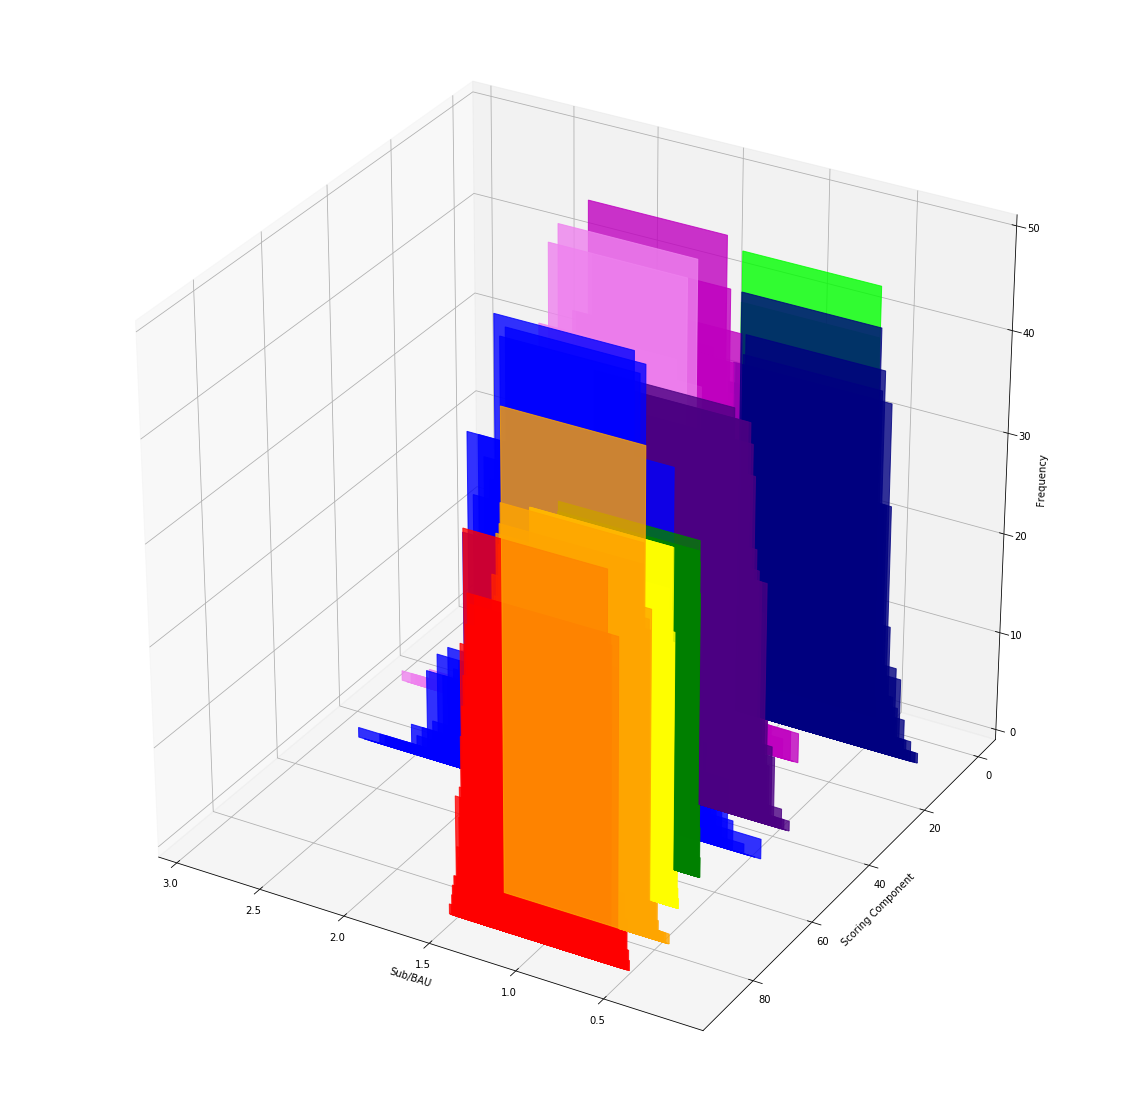

In [45]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
nbins = 50
for i,(c, z) in enumerate(zip(['r','orange','yellow','green','blue','indigo','violet','m','navy','lime'], [90,80,70,60,50,40,30, 20, 10, 0])):
    ys = wide_scores.T.iloc[i]

    hist, bins = np.histogram(ys, bins=nbins)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=z, zdir='y', color=c, ec=c, alpha=0.8)
    
ax.set_xlabel('Sub/BAU')
ax.set_ylabel('Scoring Component')
ax.set_zlabel('Frequency')

# ax.set_yticklabels(['A','B','C','D','E','F','G','H','I','J'])

ax.view_init(30, 120)




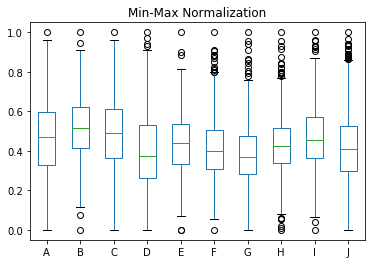

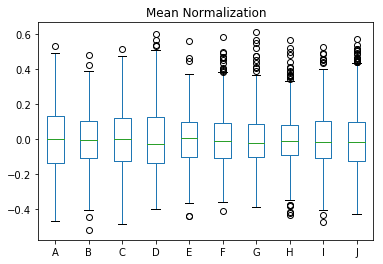

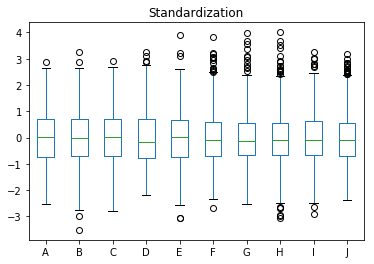

In [20]:
columns = ['A','B','C','D','E','F','G','H','I','J']
mins = np.nanmin(wide_scores.values.astype(float),axis=0)
maxs = np.nanmax(wide_scores.values.astype(float),axis=0)
denom = maxs-mins
means = np.nanmean(wide_scores.values,axis=0)
variances = wide_scores.values.var(axis=0)
stds = wide_scores.values.std(axis=0)

# min-max normalization
pd.DataFrame((wide_scores.values-mins)/denom,columns=columns).plot(kind='box',title='Min-Max Normalization')
plt.savefig('img/min_max_norm.png',format='png',dpi=150)
plt.show()

# mean normalization
pd.DataFrame((wide_scores.values-means)/denom,columns=columns).plot(kind='box',title='Mean Normalization')
plt.savefig('img/mean_norm.png',format='png',dpi=150)
plt.show()

# standardization
pd.DataFrame(((wide_scores.values-means)/stds),columns=columns).plot(kind='box',title='Standardization')
plt.savefig('img/standardization.png',format='png',dpi=150)
plt.show()

In [231]:
dict(zip(columns,wide_scores.columns.values))

{'A': 'Accessibility: Number of secondary locations accessible within 15 minutes',
 'B': 'Accessibility: Number of work locations accessible within 15 minutes',
 'C': 'Congestion: average vehicle delay per passenger trip',
 'D': 'Congestion: total vehicle miles traveled',
 'E': 'Level of service: Average bus crowding experienced',
 'F': 'Level of service: average on-demand ride wait times',
 'G': 'Level of service: average trip expenditure - secondary',
 'H': 'Level of service: average trip expenditure - work',
 'I': 'Mass transit level of service intervention: costs and benefits',
 'J': 'Sustainability: Total PM 2.5 Emissions'}

In [1]:
from sklearn.preprocessing import *

/Users/sfeygi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


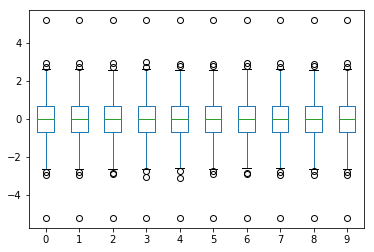

In [25]:

transformer = QuantileTransformer(output_distribution='normal')
fitted = transformer.fit(wide_scores.values)
pd.DataFrame(fitted.transform(wide_scores.values)).plot(kind='box')



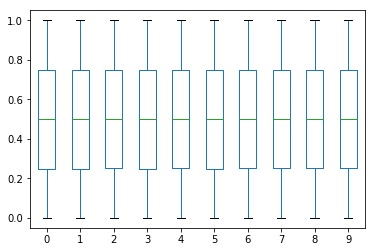

In [27]:
transformer = QuantileTransformer(output_distribution='uniform')
fitted = transformer.fit(wide_scores.values)
pd.DataFrame(fitted.transform(wide_scores.values)).plot(kind='box')